In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools, time, datetime
from collections import Counter

import os

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
warnings.simplefilter('ignore')

from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [2]:
# Read training and testing data for Dataset-1 
train_DS1 = pd.read_csv('Datasets/Dataset1_Training.csv')
test_DS1 = pd.read_csv('Datasets/Dataset1_Testing.csv')

# Read training and testing data for Dataset-2 
train_DS2 = pd.read_csv('Datasets/Dataset2_Training.csv')
test_DS2 = pd.read_csv('Datasets/Dataset2_Testing.csv')

In [3]:
# Data Preparation 

def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return labels, train, test


In [4]:
# encode the dataset

labels, train, test = encode(train_DS2, test_DS2)


In [5]:
# standardize train features using standard deviation 

scaler = StandardScaler().fit(train.values)
scaled_train = scaler.transform(train.values)


In [6]:
# Stratified Train/Test Split
    
sss = StratifiedShuffleSplit(random_state=23)
for train_index, test_index in sss.split(scaled_train, labels):
    X_train, X_test = scaled_train[train_index], scaled_train[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    

In [7]:
# Timer 

# Utility custom contextual class for calculating 
# the time taken for a certain code block to execute
    
class CodeTimer:
    
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.perf_counter() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))


In [8]:
# Array of Sklearn Classifier models 
classifiers = [
    KNeighborsClassifier(7),
    NuSVC(probability=True),    
    SVC(kernel = 'rbf', probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=100,learning_rate=.05,max_depth=6),
    GaussianNB(),
    LogisticRegression(multi_class = 'multinomial'),
    LinearDiscriminantAnalysis(),
    MLPClassifier()
]

# Array of Sklearn Classifier names 
classifier_names = []
for clf in classifiers:
    classifier_names.append(clf.__class__.__name__)


In [9]:
def runAndPredict(model, model_name, x_train, y_train, x_test, y_test):
    
    print("="*30)
    print(model_name)
    
    response = {}
    # define an object for training timer
    training_timer = CodeTimer('training')
    # define an object for testing timer 
    testing_timer = CodeTimer('testing')
    
    # fit training data
    model.fit(X_train, y_train)
    
    # calculate training time
    with training_timer:        
        train_predictions = model.predict(X_test)
                
    # calculate testing time
    with testing_timer:
        y_prediction = model.predict_proba(X_test)    
    
    # calculate the accuracy of the prediction 
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    response['testing_time'] = testing_timer.took
    response['y_prediction'] = y_prediction
    response['training_time'] = training_timer.took    
    response['accuracy_score'] = acc
    
    return response

In [10]:
# define an object for the timer 
timer = CodeTimer(name='overalltime')

model_metrics = {}

with timer:
    # run each model, fit training data and make prediction and calculate the time 
    for model, model_name in zip(classifiers, classifier_names):

        result = runAndPredict(model, model_name, X_train, y_train, X_test, y_test)

        y_prediction = result['y_prediction']

        model_metrics[model_name] = {}
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        print("="*30)

        
print(timer.took)


KNeighborsClassifier
Code block 'training' took(HH:MM:SS): 0:00:00.071586
Code block 'testing' took(HH:MM:SS): 0:00:00.055423
Accuracy: 93.7500%
NuSVC
Code block 'training' took(HH:MM:SS): 0:00:00.081710
Code block 'testing' took(HH:MM:SS): 0:00:00.120308
Accuracy: 93.7500%
SVC
Code block 'training' took(HH:MM:SS): 0:00:00.053855
Code block 'testing' took(HH:MM:SS): 0:00:00.082591
Accuracy: 94.3750%
DecisionTreeClassifier
Code block 'training' took(HH:MM:SS): 0:00:00.000266
Code block 'testing' took(HH:MM:SS): 0:00:00.000709
Accuracy: 61.2500%
RandomForestClassifier
Code block 'training' took(HH:MM:SS): 0:00:00.015684
Code block 'testing' took(HH:MM:SS): 0:00:00.016250
Accuracy: 96.8750%
GradientBoostingClassifier
Code block 'training' took(HH:MM:SS): 0:00:00.014138
Code block 'testing' took(HH:MM:SS): 0:00:00.014606
Accuracy: 80.0000%
XGBClassifier
[01:28:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used wi

                            training_time  testing_time  accuracy_score
KNeighborsClassifier             0.875687      0.457477         0.93750
NuSVC                            1.000000      1.000000         0.93750
SVC                              0.657981      0.684635         0.94375
DecisionTreeClassifier           0.000000      0.000000         0.61250
RandomForestClassifier           0.189306      0.129942         0.96875
GradientBoostingClassifier       0.170325      0.116199         0.80000
XGBClassifier                    0.072419      0.035766         0.86250
GaussianNB                       0.156998      0.103234         0.78125
LogisticRegression               0.002224      0.001827         0.96250
LinearDiscriminantAnalysis       0.000177      0.000514         0.96875
MLPClassifier                    0.003442      0.001563         0.94375


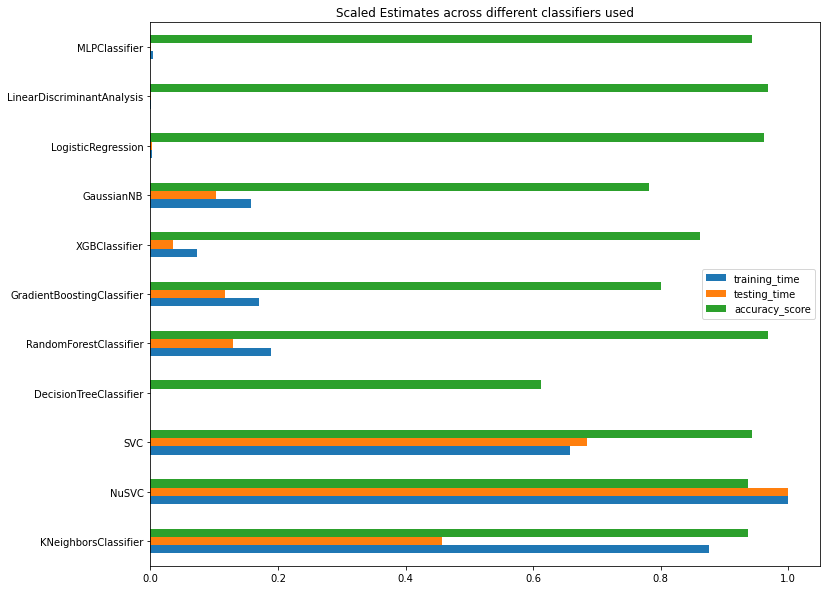

In [11]:
# convert model_metrics into panda data frame
model_estimates = pd.DataFrame(model_metrics).transpose()


#print out across model estimations and accuracy score bar chart
model_estimates['testing_time'] = model_estimates['testing_time'].astype('float64')
model_estimates['training_time'] = model_estimates['training_time'].astype('float64')

#scaling time parameters between 0 and 1
model_estimates['testing_time'] = (model_estimates['testing_time']- model_estimates['testing_time'].min())/(model_estimates['testing_time'].max()- model_estimates['testing_time'].min())
model_estimates['training_time'] = (model_estimates['training_time']- model_estimates['training_time'].min())/(model_estimates['training_time'].max()- model_estimates['training_time'].min())

print(model_estimates)
model_estimates.plot(kind='barh',figsize=(12, 10))
plt.title("Scaled Estimates across different classifiers used")
plt.show()